## Unlocking the power of gradient-boosted trees using LightGBM

### PyData London 2022 presentation
See slides here and talk here.

### Data: Kaggle house prices prediction
See competition [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/).

**The point of this notebook is showing how little it takes to get a reasonable baseline going.** It is not supposed to be a good Kaggle submission. To understand the notebook reading the slides is highly recommended.

In [1]:
import pandas as pd
import lightgbm as lgbm
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
import shap

shap.initjs()

## Data Wrangling and EDA

In [2]:
# Load train data
train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
train["train"] = True

In [3]:
# Load test data
test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")
test["train"] = False
test["SalePrice"] = np.nan # Target variable is missing for the test set

In [4]:
df = pd.concat((train, test))

In [5]:
df

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... PoolQC  Fence MiscFeature MiscVal MoSold  \
0            Lvl    AllPub  ...    NaN    NaN         NaN       0      2   
1            Lvl    AllPub  ...    NaN    NaN         NaN       0      5   
2            Lvl    AllPub  ...    NaN    NaN         NaN       0      9   
3            Lvl    AllPub  ...    NaN    NaN         NaN       0      2   
4            Lvl    AllPub  ...    NaN    NaN         NaN       0     12   
...          ...       ...  ...    ...    ...         ...     ...    ...   
1454         Lvl    AllPub  ...    NaN    NaN         NaN       0      6   
1455         Lvl    AllPub  ...    NaN    NaN         NaN       0      4   
1456         Lvl    AllPub  ...    NaN    NaN         NaN       0      9   
1457         Lvl    AllPub  ...    NaN  MnPrv        Shed     700      7   
1458         Lvl    AllPub  ...    NaN    NaN         NaN       0     11   

     YrSold SaleType  SaleCondition  SalePrice  train  
0      2008       WD         Normal   208500.0   True  
1      2007       WD         Normal   181500.0   True  
2      2008       WD         Normal   223500.0   True  
3      2006       WD        Abnorml   140000.0   True  
4      2008       WD         Normal   250000.0   True  
...     ...      ...            ...        ...    ...  
1454   2006       WD         Normal        NaN  False  
1455   2006       WD        Abnorml        NaN  False  
1456   2006       WD        Abnorml        NaN  False  
1457   2006       WD         Normal        NaN  False  
1458   2006       WD         Normal        NaN  False  

[2919 rows x 82 columns]

In [6]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [23]:
profile.to_file("pandas_profile_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
minimal_profile = ProfileReport(df, title="Pandas Profiling Report", minimal=True)
minimal_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Find out the categorical features and make them the "category" type
# LightGBM will automatically interpret those columns as categorical features
cat_features = [c for c, dt in df.dtypes.items() if dt=='object']
df[cat_features] = df[cat_features].astype("category")

## First approach: default parameters fit

In [9]:
# No feature engineering or encoding is done even though we have:
# 1. Numerical features with different scale and skewness
# 2. Categorical features
# 3. Missing values
X = df[df.train].drop(["train", "SalePrice"], axis=1)
y = np.log(df[df.train]["SalePrice"]) # We need to predict the log(price)

In [10]:
# Test set for scoring later
test_X = df[~df.train].drop(["train", "SalePrice"], axis=1)

In [11]:
# Basic LightGBM with default parameters
reg = lgbm.LGBMRegressor(random_state=42)
reg.fit(X, y)

LGBMRegressor(random_state=42)

In [12]:
# First submission: default parameters
df.loc[~df.train, "SalePrice"] = np.exp(reg.predict(test_X))
df.loc[~df.train, ["Id", "SalePrice"]].to_csv("submission.csv", index=False)

## Second approach: early stopping fit

In [13]:
# Getting a validation example for usage in early sotpping
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
# Use different parameters for early stopping:
# 1000 estimators as the maximum number of iterations instead of the default (100)
# Lower learning rate (0.01) instead of the default (0.1) to make a better use of more trees
reg_es = lgbm.LGBMRegressor(learning_rate=0.01, n_estimators=1000, random_state=42)

In [15]:
es = lgbm.early_stopping(5) # Stops after 5 rounds of no validation set improvements

In [16]:
# Fit with early stopping
reg_es.fit(train_X, train_y, callbacks=[es], eval_set=(val_X, val_y))

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[546]	valid_0's l2: 0.018072


LGBMRegressor(learning_rate=0.01, n_estimators=1000, random_state=42)

In [17]:
# Retrain with the optimal number of iterations (something important to do in a small data setting)
reg_es.n_estimators = reg_es.best_iteration_
reg_es.fit(X, y)

LGBMRegressor(learning_rate=0.01, n_estimators=546, random_state=42)

In [18]:
# Second submission: early stopping
df.loc[~df.train, "SalePrice"] = np.exp(reg.predict(test_X))
df.loc[~df.train, ["Id", "SalePrice"]].to_csv("submission_es.csv", index=False)

## Model interpretation with SHAP

In [19]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(test_X)

In [20]:
# Look at the first test example (below average prediction)
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X.iloc[0,:])

In [21]:
# Look at the third test example (above average prediction)
shap.force_plot(explainer.expected_value, shap_values[2,:], test_X.iloc[2,:])

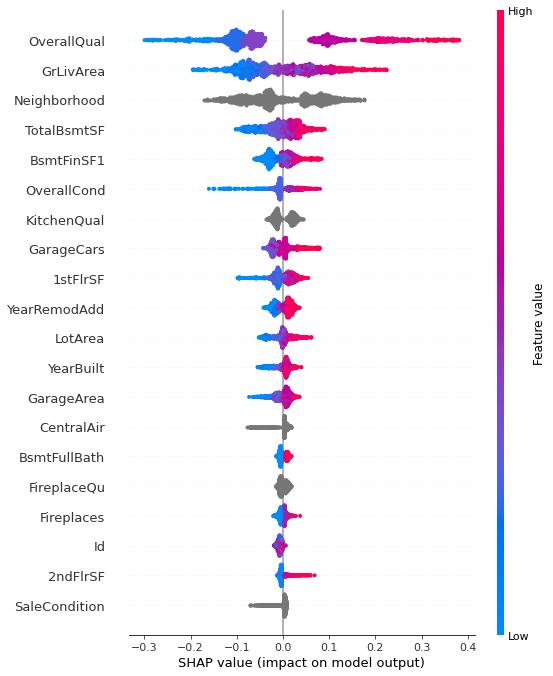

In [22]:
# Look at the whole test set
shap.summary_plot(shap_values, test_X)

## Where to go from now?
* First you need to build a proper evaluation procedure
* You can try changing the objective function (e.g. MAE loss)
* You can tune the parameters using random search or bayesian optimization
* You can do feature engineering and ensemble models or any standard competition modelling trick